In [21]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CosineSimilarity

from gw_grb_correlation.Fermi.data_preprocessing import create_dataframe_and_name_column_from_data_files
from gw_grb_correlation.Fermi.util import process_data, cosine_similarity_loss

from gw_grb_correlation.Fermi.visualization import evaluate_model_and_plot_accurracy
from gw_grb_correlation.Fermi.util import convert_cartesian_to_spherical

In [22]:
# Load data
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')

# List of detectors
detectors = [f"n{i}" for i in range(10)] + ["na", "nb", "b0", "b1"]

# Define input columns
PH_CNT_columns = [f"{detector}_PH_CNT" for detector in detectors]
TRIG_columns = [f"{detector}_TRIG" for detector in detectors]
Orientation_columns = ['QSJ_1', 'QSJ_2', 'QSJ_3', 'QSJ_4']
fermi_data[PH_CNT_columns] = np.array(fermi_data[PH_CNT_columns].values.astype(np.float64)) * np.array(fermi_data[TRIG_columns].values.astype(np.float64))

all_data_columns = Orientation_columns + TRIG_columns + PH_CNT_columns

In [23]:
from tensorflow.keras.callbacks import Callback

class MinimalLogger(Callback):
    def __init__(self, every=50):
        self.every = every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

def train_GRB_localization_model(fermi_data, input_columns):
    """
    Train a GRB localization model using the provided Fermi data.

    Parameters:
    fermi_data (DataFrame): The Fermi data containing the necessary columns.
    input_columns (list): List of input columns to be used for training.

    Returns:
    model: The trained Keras model.
    """
    
    # Split the data into training and testing sets
    X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

    # Define model with Dropout
    Dropout_rate = 0.05
    model = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(Dropout_rate),
        Dense(512, activation='relu'),
        Dropout(Dropout_rate),
        Dense(512, activation='relu'),
        Dropout(Dropout_rate),
        Dense(3, activation=None),  # Output layer, no activation
    ])


    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.00002),
        loss=cosine_similarity_loss,
        metrics=[CosineSimilarity(name='cosine_similarity')]
    )
    
    # Print model summary
    model.summary()

    # Train model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=400,
        batch_size=16,
        validation_data=(X_test_scaled, y_test),
        callbacks=[MinimalLogger(every=5)]
    )

    model_path = "model.h5"
    # Save the trained model
    model.save(model_path)
    print(f"Model trained and saved as {model_path}")

    # Evaluate model and plot accuracy
    train_acc, val_acc = evaluate_model_and_plot_accurracy(model, history, X_test_scaled, y_test)
    return model, X_scaled, val_acc

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,467 (1.28 MB)

 Trainable params: 334,467 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: -0.0074 - loss: 0.0074Epoch 1: loss=-0.0046, val_loss=-0.0256
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - cosine_similarity: -0.0073 - loss: 0.0073 - val_cosine_similarity: 0.0256 - val_loss: -0.0256
Epoch 2/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - cosine_similarity: 0.0354 - loss: -0.0354 - val_cosine_similarity: 0.0508 - val_loss: -0.0508
Epoch 3/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.0745 - loss: -0.0745 - val_cosine_similarity: 0.0805 - val_loss: -0.0805
Epoch 4/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - cosine_similarity: 0.1483 - loss: -0.1483 - val_cosine_similarity: 0.1135 - val_loss: -0.1135
Epoch 5/400
 97/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.1967 - loss: -0.1967Epoch 5: loss=-0.1925, val_loss=-0.1303
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.1965 - loss: -0.1965 - val_cosine_similarity: 0.1303 - val_loss: -0.1303
Epoch 

Model trained and saved as model.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.8581 - loss: -0.8581 
Test Loss: -0.8578
Cosine Similarity: 0.8578
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean norm of predicted vectors: 0.26579592
Standard deviation of norms: 0.17077017


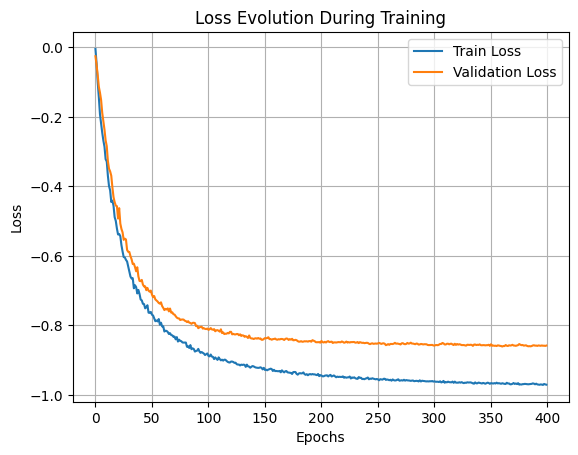

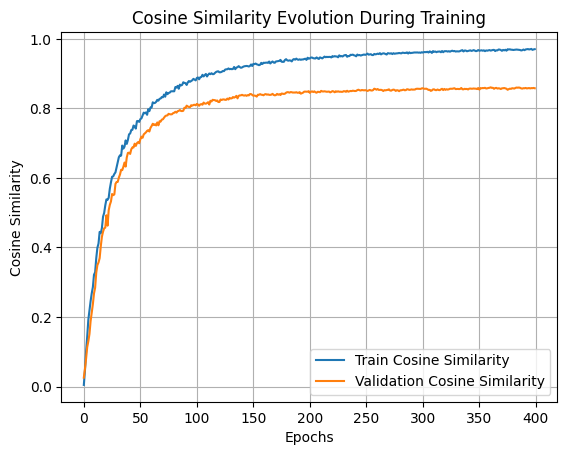

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [24]:
# Train the model with all data
model, X_scaled, val_acc_all_data = train_GRB_localization_model(fermi_data, all_data_columns)

# Make predictions based on the trained model
predictions = model.predict(X_scaled)

# Convert predictions from Cartesian to spherical coordinates (RA, DEC)
RA_DEC_predictions = np.array([convert_cartesian_to_spherical(pred) for pred in predictions])
fermi_predict_data = fermi_data.copy()

fermi_predict_data['RA'] = RA_DEC_predictions[:, 0]
fermi_predict_data['DEC'] = RA_DEC_predictions[:, 1]

# Save the predictions to a CSV file
fermi_predict_data.to_csv("fermi_predict_data.csv", index=False)

In [25]:
"""
We will now do time correlation analysis again with the new localization data predicted by the model.
We will filter out short GRB data and find matched GRB-GW event pairs using the new location data of short GRBs.
"""
from gw_grb_correlation.Fermi.util import filtering
from gw_grb_correlation.Fermi.util import read_GW_data, remove_duplicate_times_in_gw_data, compare_time_within_range

# Filter out short GRB data
short_GRB_data = filtering(fermi_predict_data, criteria={'T90': lambda x: x <= 2.1})

# Load GW data
gw_data = read_GW_data(f"./gw_data/totalgwdata.csv")
gw_times = remove_duplicate_times_in_gw_data(gw_data)

# Find matched GRB-GW event pairs using new location data of short GRBs from the model
match = compare_time_within_range(short_GRB_data, gw_times, time_range_seconds=86400*3)
filtered_gw_events = gw_data[gw_data['times'].isin(match['gw_time'])]

# Save the matched GRB-GW event pairs and filtered GW events to CSV files
match.to_csv("GRB_GW_event_pairs_predict.csv", index=False)
filtered_gw_events.to_csv("Filtered_GW_events_predict.csv", index=False)


Data from ./gw_data/totalgwdata.csv loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418227 entries, 0 to 2418226
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ra          float64
 2   dec         float64
 3   times       float64
 4   weights     float64
dtypes: float64(4), int64(1)
memory usage: 92.2 MB
None
   Unnamed: 0        ra       dec         times   weights
0           0  1.891867 -1.250744  1.126259e+09  0.000024
1           1  1.254342 -1.228042  1.126259e+09  0.000024
2           2  1.666787 -1.279668  1.126259e+09  0.000024
3           3  1.863250 -1.261367  1.126259e+09  0.000024
4           4  0.994238 -1.036272  1.126259e+09  0.000024
Number of unique times after applying threshold: 91
First few unique times:
               times                          date
0       1.126259e+09 2015-09-14 09:51:02.000000000
44173   1.128679e+09 2015-10-12 09:55:00.000000000
79620   1.135136e+09 20

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gw_grb_correlation\Fermi\util.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = pd.to_numeric(fermi_data['TSTART'], errors='coerce')
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gw_grb_correlation\Fermi\util.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Found 44 matches within 259200 seconds.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
 95/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: -0.0030 - loss: 0.0030Epoch 1: loss=0.0018, val_loss=0.0015
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - cosine_similarity: -0.0030 - loss: 0.0030 - val_cosine_similarity: -0.0015 - val_loss: 0.0015
Epoch 2/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.0350 - loss: -0.0350 - val_cosine_similarity: 0.0170 - val_loss: -0.0170
Epoch 3/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - cosine_similarity: 0.0270 - loss: -0.0270 - val_cosine_similarity: 0.0199 - val_loss: -0.0199
Epoch 4/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - cosine_similarity: 0.0294 - loss: -0.0294 - val_cosine_similarity: 0.0109 - val_loss: -0.0109
Epoch 5/400
 92/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.0791 - loss: -0.0791Epoch 5: loss=-0.0799, val_loss=-0.0247
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - cosine_similarity: 0.0786 - loss: -0.0786 - val_cosine_similarity: 0.0247 - val_loss: -0.0247
Epoch 6/4

Model trained and saved as model.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - cosine_similarity: 2.5043e-04 - loss: -2.5043e-04
Test Loss: -0.0376
Cosine Similarity: 0.0376
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean norm of predicted vectors: 0.15764196
Standard deviation of norms: 0.2715665


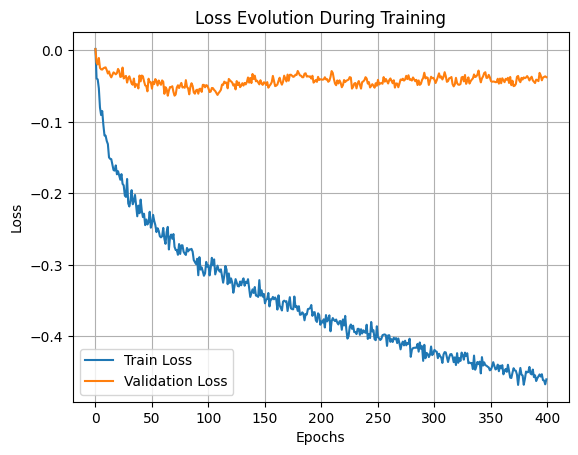

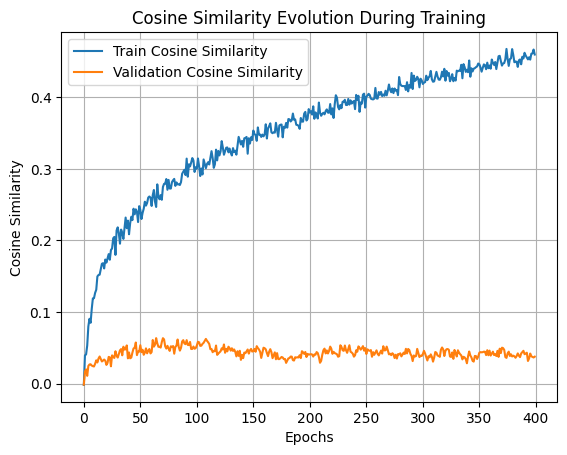

In [26]:
# This time, we test model trained without spacecraft orientation data
no_spacecraft_columns = TRIG_columns + PH_CNT_columns # No Spacecraft Orientation
model, X_scaled, val_acc_no_ori = train_GRB_localization_model(fermi_data, no_spacecraft_columns)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,675 (1.27 MB)

 Trainable params: 332,675 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
 94/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - cosine_similarity: 0.0381 - loss: -0.0381Epoch 1: loss=-0.0314, val_loss=-0.0313
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - cosine_similarity: 0.0375 - loss: -0.0375 - val_cosine_similarity: 0.0313 - val_loss: -0.0313
Epoch 2/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - cosine_similarity: 0.0854 - loss: -0.0854 - val_cosine_similarity: 0.0688 - val_loss: -0.0688
Epoch 3/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - cosine_similarity: 0.1512 - loss: -0.1512 - val_cosine_similarity: 0.1300 - val_loss: -0.1300
Epoch 4/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.2141 - loss: -0.2141 - val_cosine_similarity: 0.1832 - val_loss: -0.1832
Epoch 5/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.2559 - loss: -0.2559Epoch 5: loss=-0.2501, val_loss=-0.2198
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.2558 - loss: -0.2558 - val_cosine_similarity: 0.2198 - val_loss: -0.2198
Epoch 

Model trained and saved as model.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.5976 - loss: -0.5976 
Test Loss: -0.6061
Cosine Similarity: 0.6061
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean norm of predicted vectors: 0.121104285
Standard deviation of norms: 0.2736982


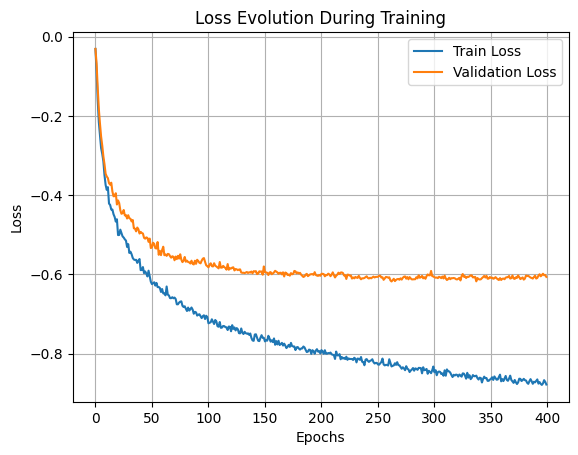

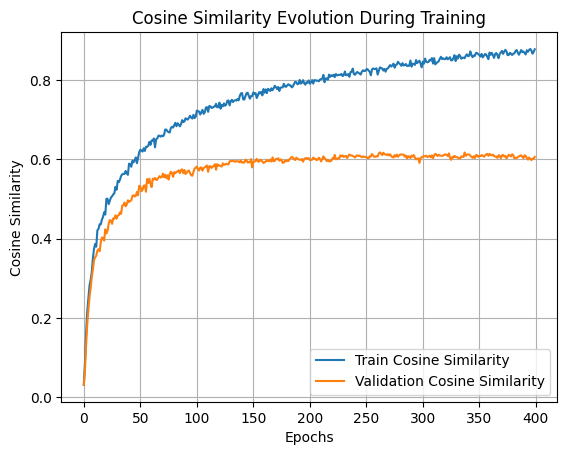

In [27]:
# This time, we test model trained without trigger data
no_trigger_columns = PH_CNT_columns + Orientation_columns # No Trigger Data
model, X_scaled, val_acc_no_trig = train_GRB_localization_model(fermi_data, no_trigger_columns)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,675 (1.27 MB)

 Trainable params: 332,675 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
 98/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.0206 - loss: -0.0206Epoch 1: loss=-0.0066, val_loss=-0.0380
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - cosine_similarity: 0.0200 - loss: -0.0200 - val_cosine_similarity: 0.0380 - val_loss: -0.0380
Epoch 2/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - cosine_similarity: 0.0470 - loss: -0.0470 - val_cosine_similarity: 0.0863 - val_loss: -0.0863
Epoch 3/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - cosine_similarity: 0.1268 - loss: -0.1268 - val_cosine_similarity: 0.1214 - val_loss: -0.1214
Epoch 4/400
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.1619 - loss: -0.1619 - val_cosine_similarity: 0.1562 - val_loss: -0.1562
Epoch 5/400
 99/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.2413 - loss: -0.2413Epoch 5: loss=-0.2313, val_loss=-0.1754
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.2410 - loss: -0.2410 - val_cosine_similarity: 0.1754 - val_loss: -0.1754
Epoch 6

Model trained and saved as model.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - cosine_similarity: 0.9171 - loss: -0.9171 
Test Loss: -0.9211
Cosine Similarity: 0.9211
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean norm of predicted vectors: 0.26156485
Standard deviation of norms: 0.056616597


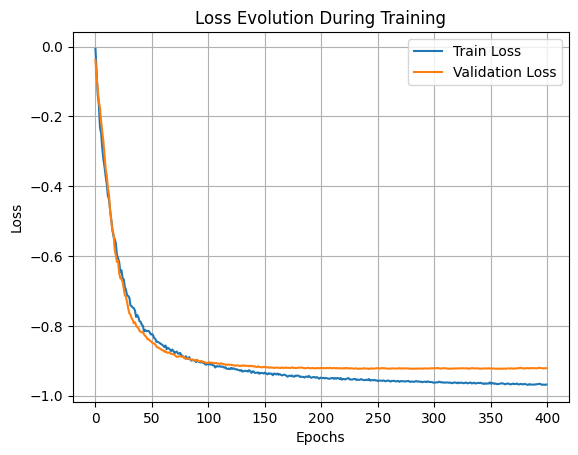

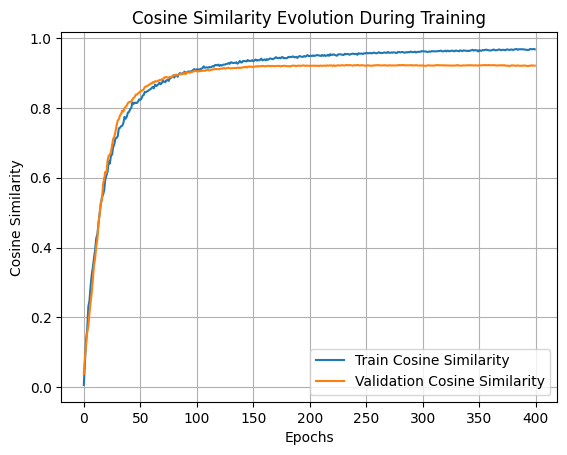

In [28]:
# This time, we test model trained without photon count data
no_pht_cnt_columns = TRIG_columns + Orientation_columns # No Photon Count Data
model, X_scaled, val_acc_no_pht_cnt = train_GRB_localization_model(fermi_data, no_pht_cnt_columns)

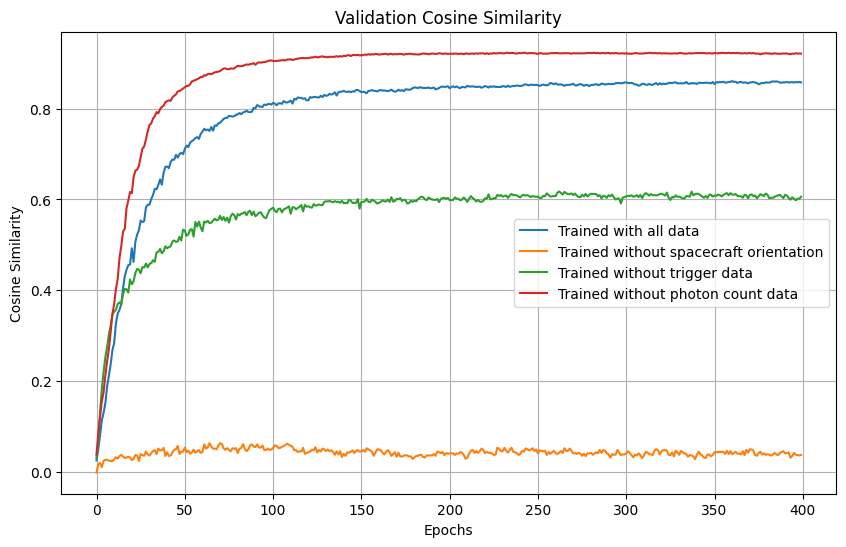

In [29]:
# Compare the validation accuracies of the models trained with different data combinations
plt.figure(figsize=(10, 6))
plt.plot(val_acc_all_data, label='Trained with all data')
plt.plot(val_acc_no_ori, label='Trained without spacecraft orientation')
plt.plot(val_acc_no_trig, label='Trained without trigger data')
plt.plot(val_acc_no_pht_cnt, label='Trained without photon count data')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity')
plt.title('Validation Cosine Similarity')
plt.legend()
plt.grid(True)
plt.show()